In [1]:
'''
Author: Anonymized
Email: Anonymized
Description: 
(1) Plots the evolution of loss curvature vs epochs for ImageNet
(2) Plots how many repeated images are captures by high curvature samples
(3) Visualizes high curvature examples after training on vanilla ImageNet
(4) Computes the cosine similarity between 
FZ score (https://pluskid.github.io/influence-memorization/#imagenet-dl) 
and loss curvature for ImageNet
'''

import numpy as np
import pandas as pd

top_k = 50000
npz = np.load('./analysis_checkpoints/imagenet/imagenet_index.npz', allow_pickle=True)
fz_scores = pd.DataFrame.from_dict({item: npz[item] for item in ['tr_filenames', 'tr_labels', 'tr_mem']})
fz_scores['tr_filenames'] = fz_scores['tr_filenames'].astype(str)

cr_npz = np.load('./analysis_checkpoints/imagenet/imagenet_index_curv.npz', allow_pickle=True)
curv_scores = pd.DataFrame.from_dict({item: cr_npz[item] for item in ['tr_filenames', 'cr_labels', 'tr_curv']})
curv_scores['idx'] = np.arange(len(curv_scores))
merged = fz_scores.merge(curv_scores, on='tr_filenames', how='inner')
merged.sort_values(by='tr_mem', inplace=True, ascending=False)
indices_top_k = merged['idx'][:top_k].to_numpy()

In [2]:
import torch

scores = []

# Epochs for wd0 was split on 4 gpus, so we combines them with this list because of that
epochs = list(range(0, 50, 4)) + list(range(50, 100, 4)) + list(range(100, 150, 4)) + list(range(150, 200, 4))
avg_score = None
high_fz_scores = []

for epoch in epochs:
    score = torch.abs(torch.load(f"./curv_scores/regr_scores_{epoch}.pt"))
    sorted_score, indices = torch.sort(score, stable=True, descending=True)
    if avg_score is None:
        avg_score = score
    else:
        avg_score += score

    scores.append(score.mean().item())
    high_fz_scores.append(score[indices_top_k].mean())

test_scores = []
avg_test_scores = None
test_epochs = range(0, 200, 4)
for epoch in test_epochs:
    score = torch.abs(torch.load(f"./curv_scores/regr_scores_{epoch}_test.pt"))
    test_scores.append(score.mean().item())


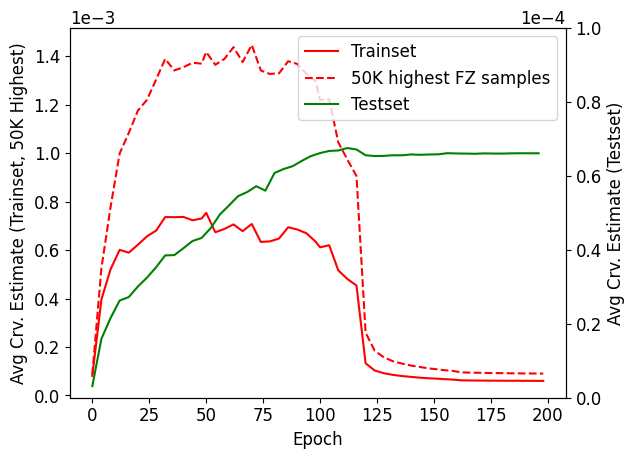

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.rcParams.update({'font.size': 12})
ax = fig.add_subplot(111)
avg_score = avg_score / len(epochs)
tr_line = ax.plot(epochs, scores, c='r', label='Trainset')
fz_tr_line = ax.plot(epochs, high_fz_scores, c='r', ls='dashed', label=f'{top_k // 1000}K highest FZ samples')
ax.set_xlabel('Epoch')
ax.set_ylabel('Avg Crv. Estimate (Trainset, 50K Highest)')
ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useOffset=False)
ax2 = ax.twinx()
tst_line = ax2.plot(test_epochs, test_scores, c='g', label='Testset')
ax2.set_ylabel('Avg Crv. Estimate (Testset)')
ax2.set_ylim(0, 10e-5)
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useOffset=False)
ax2.ticklabel_format(style='plain', axis='x', scilimits=(0,0), useOffset=False)
lns = tr_line + fz_tr_line + tst_line
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper right')
plt.savefig("./ImageNet_Curvature_vs_Epochs.svg")
plt.show()

In [4]:
from utils.load_dataset import load_dataset
import numpy as np
import cv2
from tqdm import tqdm

hsh = cv2.img_hash.BlockMeanHash_create()
def get_np_img_hash(np_img:np.array):
    np_img = np_img * 255
    np_img = np_img.astype(np.uint8)
    cv_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)
    hsh_val = bytes(hsh.compute(cv_img))
    top = ''.join([format(i, 'x') for i in hsh_val[:16]])
    bottom = ''.join([format(i, 'x') for i in hsh_val[16:]])
    return top + bottom

dataset = load_dataset(
    dataset="imagenet",
    train_batch_size=256,
    test_batch_size=256,
    val_split=0.00,
    augment=False,
    shuffle=False,
    random_seed=0,
    distributed=False)

try:
    image_hashes = torch.load("./curv_scores/hash_repeat.pt")
except:
    image_hashes = []
    for idx in tqdm(range(dataset.train_length)):
        image, label = dataset.train_loader.dataset.__getitem__(idx)
        image_np = image.permute(1,2,0).numpy()
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
        img_hash = get_np_img_hash(image_np)
        image_hashes.append(img_hash)
    
    torch.save(image_hashes, "./curv_scores/hash_repeat.pt")


In [5]:
# Epochs for wd0 was split on 4 gpus, so we combines them with this list because of that 
epochs =  list(range(162, 200, 4))
avg_score = None

for epoch in epochs:
    score = torch.abs(torch.load(f"./curv_scores/scores_{epoch}.pt"))
    sorted_score, indices = torch.sort(score, stable=True, descending=True)
    if avg_score is None:
        avg_score = score
    else:
        avg_score += score

sorted_score, indices = torch.sort(avg_score, stable=True, descending=True)

def find_duplicates(arr):
    duplicates_dict = {}
    for img_idx, img_hash in enumerate(arr):
        if img_hash in duplicates_dict:
            duplicates_dict[img_hash].append(img_idx)
        else:
            duplicates_dict[img_hash] = [img_idx]
    return duplicates_dict

images_with_hash = find_duplicates(image_hashes)

In [ ]:
import numpy as np

plot_hash_duplicates = False
images = []
labels = []
total_repeats_in_top_k = 0
cdf_top_k_repeats = []
img_nums = []

total_repeat_in_dataset = 0
for img_hsh, img_idx_list in images_with_hash.items():
    if len(img_idx_list) > 1:
        total_repeat_in_dataset += len(img_idx_list)

print(f"Total repeats identified via image hashes in ImageNet {total_repeat_in_dataset}")

for img_num, idx in enumerate(indices):
    img_hash = image_hashes[idx]
    images_with_this_hash = images_with_hash[img_hash]
    if len(images_with_this_hash) > 1:
        total_repeats_in_top_k += 1
        cdf_top_k_repeats.append(total_repeats_in_top_k)
        img_nums.append(img_num)

if plot_hash_duplicates:
    plt.plot(np.array(img_nums) / len(indices) , np.array(cdf_top_k_repeats) / total_repeats_in_top_k)
    plt.ylabel('Percentage of curv identified repeats to total repeats via hash')
    plt.xlabel('Sorted by curvature scores percentage size of dataset')
    plt.show()

total_repeats_in_top_k = 0
num_images = 100
dupl_images = []
max_dupl = 0
all_images = []
all_labels = []
done_idxs = set()
for curv_rank, idx in enumerate(indices[:num_images]):
    if idx.item() in done_idxs:
        continue
    image, label = dataset.train_loader.dataset.__getitem__(idx)
    image_np = image.permute(1,2,0).numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    img_hash = get_np_img_hash(image_np)
    images_with_this_hash = images_with_hash[img_hash]

    # Update image from sorted rank and add the label
    images.append(image_np)
    all_images.append(image_np)

    if len(images_with_this_hash) > 1:
        labels.append((label, idx, curv_rank, True))
        all_labels.append((label, idx, curv_rank, True))
        total_repeats_in_top_k += 1
        cdf_top_k_repeats.append(total_repeats_in_top_k)
    else:
        labels.append((label, idx, curv_rank, False))
        all_labels.append((label, idx, curv_rank, False))

    done_idxs.add(idx.item())

    if len(images_with_this_hash) > max_dupl:
        max_dupl = len(images_with_this_hash)
    
    dupl_images_current = []
    for dupl_img_idx in images_with_this_hash:
        if dupl_img_idx == idx.item() or dupl_img_idx in done_idxs:
            continue
        image_dp, label_dp = dataset.train_loader.dataset.__getitem__(dupl_img_idx)
        image_dp_np = image_dp.permute(1,2,0).numpy()
        image_dp_np = (image_dp_np - image_dp_np.min()) / (image_dp_np.max() - image_dp_np.min())
        dupl_images_current.append((image_dp_np, label_dp))
        curv_rank = np.where(indices == dupl_img_idx)[0][0]
        all_images.append(image_dp_np)
        all_labels.append((label_dp, dupl_img_idx, curv_rank, True))
        done_idxs.add(dupl_img_idx)

    dupl_images.append(dupl_images_current)

print(f"Hash repeats in top {num_images}:{total_repeats_in_top_k}")

Original Label, Dupl Img Label
red_wine,corkscrew*
assault_rifle,rifle*
sunglass,
shovel,
nematode,
velvet,poncho*
CD_player,cassette_player*
hummingbird,
green_snake,vine_snake*
loggerhead,
mortarboard,
cradle,crib*
folding_chair,
gong,chime*
chime,gong*
muzzle,
Sussex_spaniel,
pedestal,
cauliflower,head_cabbage*
slug,
space_bar,computer_keyboard*
vine_snake,green_snake*
slide_rule,
mouse,joystick*
syringe,
breastplate,cuirass*
corkscrew,
tub,bathtub*
long-horned_beetle,
CD_player,tape_player*
rock_crab,fiddler_crab*
stopwatch,digital_clock*
African_chameleon,
rocking_chair,
gown,velvet*
schipperke,miniature_pinscher*
brassiere,
jellyfish,
loudspeaker,
cassette,cassette_player*
gas_pump,
cassette,cassette_player*
king_penguin,
spotlight,
rule,
bathtub,tub*
fountain,
gong,
digital_clock,digital_watch*
crash_helmet,


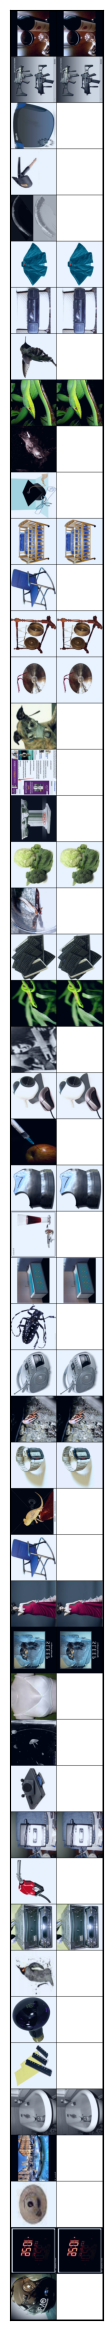

In [7]:
# Validate manually duplicated identified via hash look same but labels are different
import torchvision
plt.rcParams["savefig.bbox"] = 'tight'

import json

class_idx = json.load(open("./analysis_checkpoints/imagenet/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

def show(imgs, size=None):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    if size is not None:
        fig.set_size_inches(size[0], size[1])
    for i, img in enumerate(imgs):
        image_np = img.permute(1,2,0).numpy()
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
        axs[0, i].imshow(np.asarray(image_np))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

validation_img_list = []
viz_idxs = list(range(0, 50))
print('Original Label, Dupl Img Label')
for idx in viz_idxs:
    img = images[idx]
    img = torch.Tensor(img).permute(2,1,0)
    print(idx2label[labels[idx][0]], end=',')
    validation_img_list.append(img)
    dupl_img_arr = dupl_images[idx]
    for dupl_idx in range(max_dupl-2):
        if dupl_idx < len(dupl_img_arr):
            dupl_img = torch.Tensor(dupl_img_arr[dupl_idx][0]).permute(2,1,0)
            validation_img_list.append(dupl_img)
            print(idx2label[dupl_img_arr[dupl_idx][1]], end='*')
        else:
            validation_img_list.append(torch.ones(img.shape))

    print('')

viz_grid = torchvision.utils.make_grid(validation_img_list, nrow=max_dupl-1)
show(viz_grid, (20, 30))
    

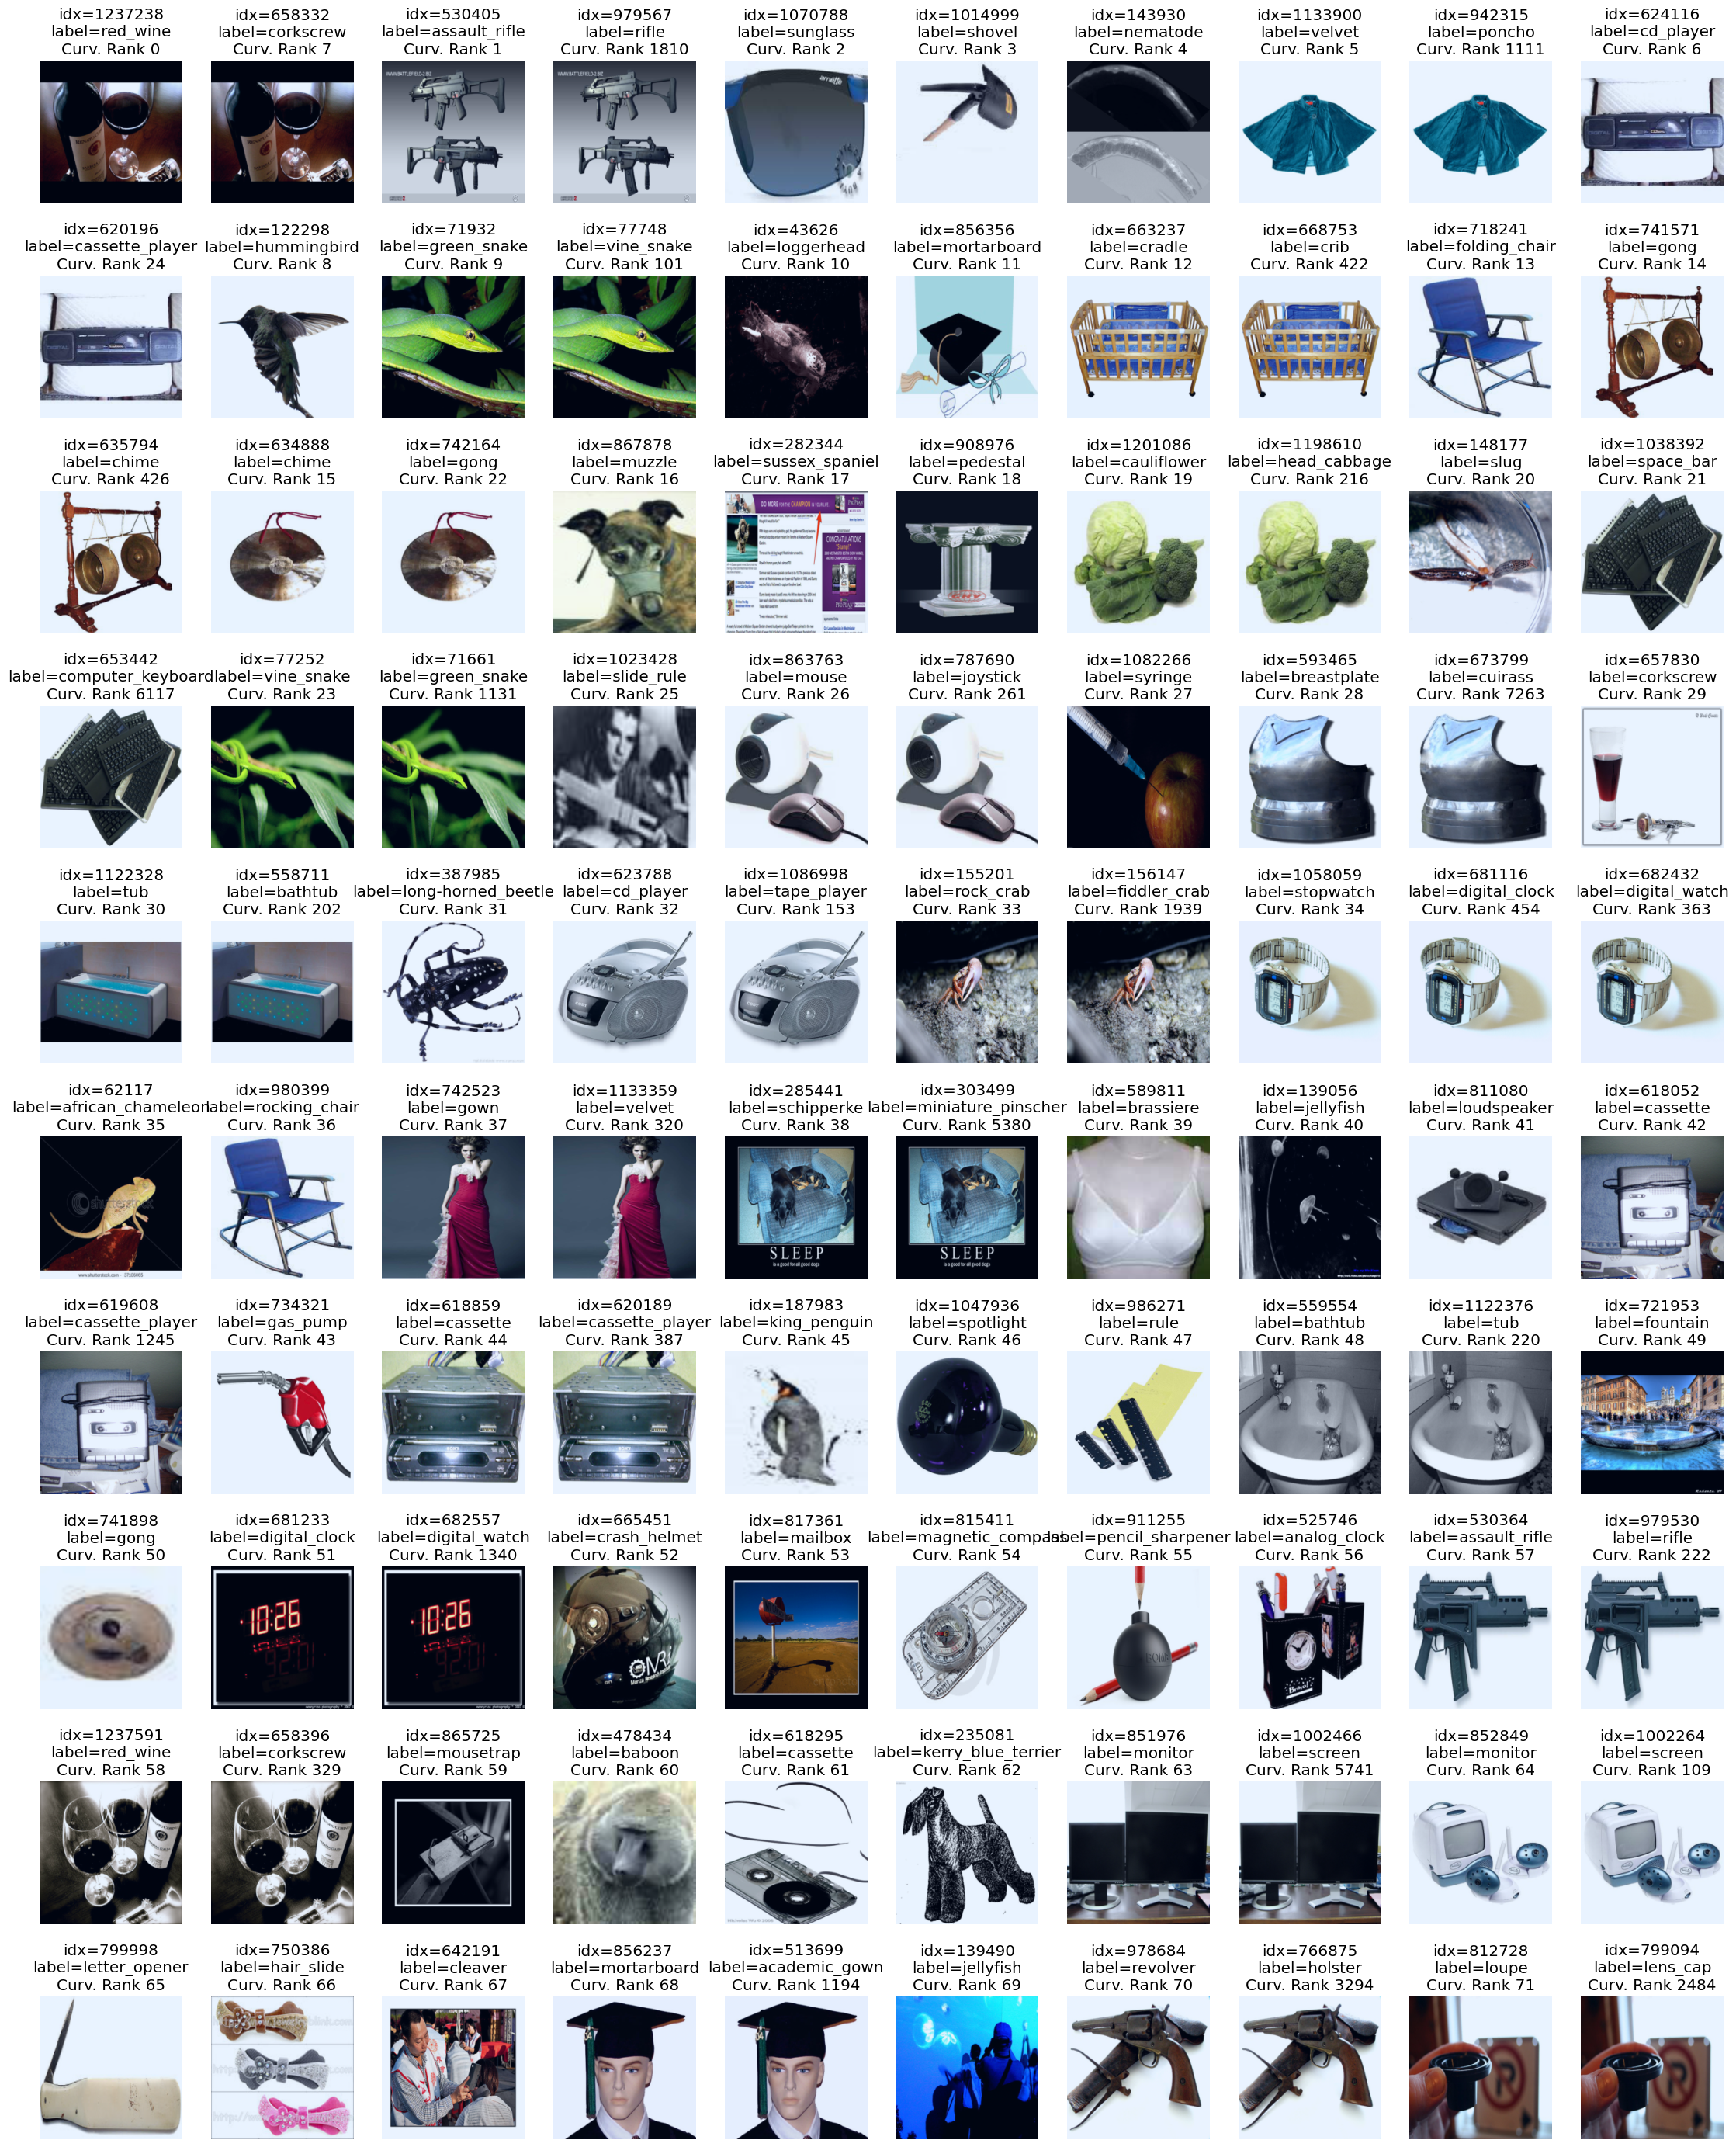

In [8]:
r = 10
c = 10
fig, axes = plt.subplots(r, c)
fig.set_size_inches(28, 25)
plt.axis('off')
no_repeated_in_plot = 0

cherry_pick_indices = np.arange(len(all_images)) # [0,2,44,6,7,8,9,15,22,24] 
i = 0
for idx, (image, label) in enumerate(zip(all_images, all_labels)):
    if idx not in cherry_pick_indices:
        continue
    if i >= r*c:
        break

    repeated = label[3]
    axis = axes[i // c, i % c]
    i += 1
    axis.imshow(image)
    if repeated:
        no_repeated_in_plot += 1
    axis.set_title(f"idx={label[1]}\nlabel={idx2label[label[0]].lower()}\nCurv. Rank {label[2]}")
    axis.set_axis_off()

fig.subplots_adjust(top=1.2)
fig.show()
fig.savefig("./out.svg")

In [9]:
'''
Code to load FZ scores and curvatures scores for imagenet and calculate the cosine similarity
'''
import torch
from torchvision.datasets import ImageFolder
from typing import Any, Tuple

# Map the scores to filename for comparison with FZ score
# Custom dataset preserves original order but get the filename
class ImageFolderWithFileName(torch.utils.data.Dataset):
    def __init__( 
        self,
        dataset:ImageFolder,
    ):
        self.dataset = dataset

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        sample, target = self.dataset.__getitem__(index)
        path, _ = self.dataset.dataset.samples[index]
        return sample, target, path
    
import os

if os.path.exists('./analysis_checkpoints/imagenet/imagenet_index_curv.npz'):
    print('Map file exits, no need to run mapping from loader to filename. Loading pre saved map')
else:
    print('No map file found, running data loader to image name map for comparison with FZ score')
    epoch_vs_scores = None
    epochs = range(154, 170, 4)

    imagenet = ImageFolderWithFileName(dataset.train_loader.dataset)
    label_from_curv = torch.load(f"./curv_scores/true_labels{epochs[0]}.pt")

    # Load precomputed imagenet curvature scores
    for epoch in epochs:
        scores_for_epoch = torch.abs(torch.load(f"./curv_scores/regr_scores_{epoch}.pt"))
        if epoch_vs_scores is None:
            epoch_vs_scores = scores_for_epoch
        else:
            epoch_vs_scores = torch.row_stack([epoch_vs_scores, scores_for_epoch])

    curv_scores = epoch_vs_scores.mean(0)

    scores_with_file_name = {'tr_filenames': [], 'tr_curv': [], 'cr_labels': []}
    for idx in tqdm(len(scores_for_epoch)):
        img, label, path = imagenet.__getitem__(idx)
        score = curv_scores[idx]
        curv_label = label_from_curv[idx]
        filename = os.path.split(path)[-1]
        scores_with_file_name['tr_filenames'].append(filename)
        scores_with_file_name['tr_curv'].append(score.item())
        scores_with_file_name['cr_labels'].append(label)

    curv_scores = pd.DataFrame.from_dict(scores_with_file_name)
    curv_scores.set_index('tr_filenames')
    np.savez('./analysis_checkpoints/imagenet/imagenet_index_curv.npz', **curv_scores)

Map file exits, no need to run mapping from loader to filename. Loading pre saved map


In [10]:
# Code to load FZ score and pre computed curvature scores for ImageNet
# This saves the scores for when weight decay is disabled

npz = np.load('./analysis_checkpoints/imagenet/imagenet_index.npz', allow_pickle=True)
fz_scores = pd.DataFrame.from_dict({item: npz[item] for item in ['tr_filenames', 'tr_labels', 'tr_mem']})
fz_scores['tr_filenames'] = fz_scores['tr_filenames'].astype(str)

cr_npz = np.load('./analysis_checkpoints/imagenet/imagenet_index_curv.npz', allow_pickle=True)
curv_scores = pd.DataFrame.from_dict({item: cr_npz[item] for item in ['tr_filenames', 'cr_labels', 'tr_curv']})

epochs = list(range(0, 50, 4)) + list(range(50, 100, 4)) + list(range(100, 150, 4)) + list(range(150, 200, 4))
cs_scores_wd0 = []
sum_scores_wd0 = []
topk_cs_scores_wd0 = []
cuml_topk_cs_scores_wd0 = []
cuml_scores_wd0 = None
cuml_topk_scores_wd0 = None

for epoch in epochs:
    curv_scores['tr_curv'] = torch.abs(torch.load(f"./curv_scores/regr_scores_{epoch}.pt")).numpy()

    # Note we do a inner join on the filename so that we can uniquely match FZ score with curvature scores
    combined_scores_df = fz_scores.merge(curv_scores, on='tr_filenames', how='inner')
    fz = combined_scores_df['tr_mem'].to_numpy()
    curv = combined_scores_df['tr_curv'].to_numpy()
    if cuml_scores_wd0 is None:
        cuml_scores_wd0 = curv
    else:
        cuml_scores_wd0 += curv

    # Perform dot product to get similiarity score
    cosine_sim = np.dot(fz, curv) / (np.linalg.norm(fz, 2) * np.linalg.norm(curv, 2))

    fz = combined_scores_df['tr_mem'].to_numpy()
    curv = cuml_scores_wd0
    cosine_sim_cuml = np.dot(fz, curv) / (np.linalg.norm(fz, 2) * np.linalg.norm(curv, 2))
    cs_scores_wd0.append(cosine_sim)
    sum_scores_wd0.append(cosine_sim_cuml)

    combined_scores_df.sort_values(by='tr_mem', inplace=True, ascending=False)
    fz = combined_scores_df['tr_mem'].to_numpy()[:top_k]
    curv = combined_scores_df['tr_curv'].to_numpy()[:top_k]
    if cuml_topk_scores_wd0 is not None:
        cuml_topk_scores_wd0 += curv
    else:
        cuml_topk_scores_wd0 = curv

    cosine_sim_top_k = np.dot(fz, curv) / (np.linalg.norm(fz, 2) * np.linalg.norm(curv, 2))
    topk_cs_scores_wd0.append(cosine_sim_top_k)

    cosine_sim_top_k_cuml = np.dot(fz, cuml_topk_scores_wd0) / (np.linalg.norm(fz, 2) * np.linalg.norm(cuml_topk_scores_wd0, 2))
    cuml_topk_cs_scores_wd0.append(cosine_sim_top_k_cuml)

In [11]:
# Code to load FZ score and pre computed curvature scores for ImageNet
# This saves the scores for when weight decay is enabled
# We ran the wd1 curvature evaluation on different epochs specifically 
# all epochs are multiples of 4, while for wd0 the split on 4 gpus started on 50, 100, 150, all of which are not
# multiples of 4 thus epochs are a little different   

wd1_epochs = list(range(0, 40, 4)) + list(range(52, 92, 4)) + list(range(104, 150, 4)) + list(range(152, 200, 4))
cs_scores_wd1 = []
sum_scores_wd1 = []
topk_cs_scores_wd1 = []
cuml_topk_cs_scores_wd1 = []
cuml_scores_wd1 = None
cuml_topk_scores_wd1 = None

for epoch in wd1_epochs:
    curv_scores['tr_curv'] = torch.abs(torch.load(f"./curv_scores/regr_scores_{epoch}_imagenet_resnet18_wd1.pt")).numpy()

    # Note we do a inner join on the filename so that we can uniquely match FZ score with curvature scores
    combined_scores_df = fz_scores.merge(curv_scores, on='tr_filenames', how='inner')
    fz = combined_scores_df['tr_mem'].to_numpy()
    curv = combined_scores_df['tr_curv'].to_numpy()
    if cuml_scores_wd1 is None:
        cuml_scores_wd1 = curv
    else:
        cuml_scores_wd1 += curv

    # Perform dot product to get similiarity score
    cosine_sim = np.dot(fz, curv) / (np.linalg.norm(fz, 2) * np.linalg.norm(curv, 2))

    fz = combined_scores_df['tr_mem'].to_numpy()
    curv = cuml_scores_wd1
    cosine_sim_cuml = np.dot(fz, curv) / (np.linalg.norm(fz, 2) * np.linalg.norm(curv, 2))
    cs_scores_wd1.append(cosine_sim)
    sum_scores_wd1.append(cosine_sim_cuml)

    combined_scores_df.sort_values(by='tr_mem', inplace=True, ascending=False)
    fz = combined_scores_df['tr_mem'].to_numpy()[:top_k]
    curv = combined_scores_df['tr_curv'].to_numpy()[:top_k]
    cosine_sim_top_k = np.dot(fz, curv) / (np.linalg.norm(fz, 2) * np.linalg.norm(curv, 2))
    topk_cs_scores_wd1.append(cosine_sim_top_k)

    if cuml_topk_scores_wd1 is not None:
        cuml_topk_scores_wd1 += curv
    else:
        cuml_topk_scores_wd1 = curv

    cosine_sim_top_k_cuml = np.dot(fz, cuml_topk_scores_wd1) / (np.linalg.norm(fz, 2) * np.linalg.norm(cuml_topk_scores_wd1, 2))
    cuml_topk_cs_scores_wd1.append(cosine_sim_top_k_cuml)

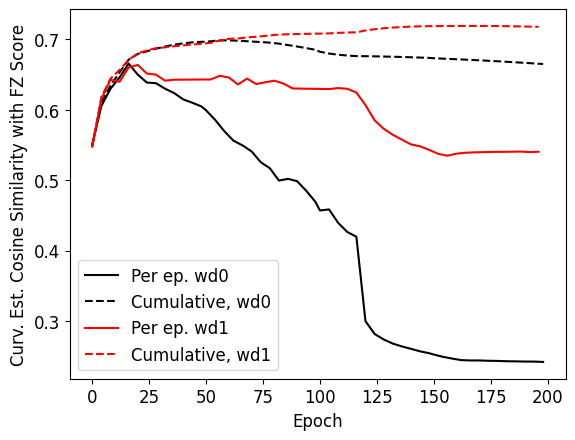

Without weight decay 0.66
With weight decay 0.72


In [12]:
# Visualize epoch vs CS for ImageNet
plt.plot(epochs, cs_scores_wd0, c='black', label='Per ep. wd0')
plt.plot(epochs, sum_scores_wd0, c='black', ls='dashed', label=f'Cumulative, wd0')
plt.plot(wd1_epochs, cs_scores_wd1, c='r', label='Per ep. wd1')
plt.plot(wd1_epochs, sum_scores_wd1, c='r', ls='dashed', label=f'Cumulative, wd1')
plt.ylabel('Curv. Est. Cosine Similarity with FZ Score')
plt.xlabel('Epoch')
plt.legend()
plt.savefig("./ImageNet_CS_vs_Epochs.svg")
plt.show()

print(f"Without weight decay { np.array(sum_scores_wd0)[-1]:.2f}")
print(f"With weight decay {np.array(sum_scores_wd1)[-1]:.2f}")

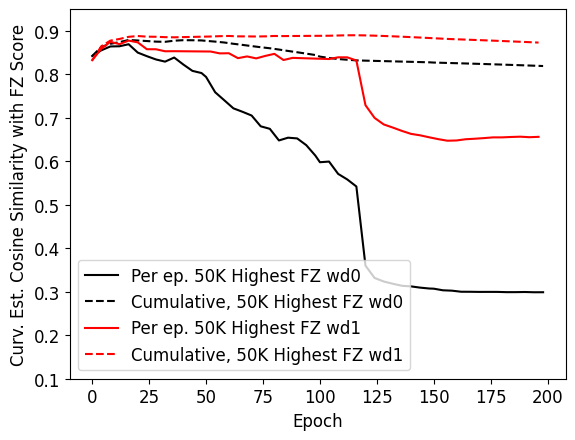

Topk Without weight decay 0.82
Topk With weight decay 0.87


In [13]:
# Visualize epoch vs CS for ImageNet
plt.plot(epochs, topk_cs_scores_wd0, c='black', label=f'Per ep. {top_k // 1000}K Highest FZ wd0')
plt.plot(epochs, cuml_topk_cs_scores_wd0, c='black', ls='dashed', label=f'Cumulative, {top_k // 1000}K Highest FZ wd0')
plt.plot(wd1_epochs, topk_cs_scores_wd1, c='r', label=f'Per ep. {top_k // 1000}K Highest FZ wd1')
plt.plot(wd1_epochs, cuml_topk_cs_scores_wd1, c='r', ls='dashed', label=f'Cumulative, {top_k // 1000}K Highest FZ wd1')
plt.ylabel('Curv. Est. Cosine Similarity with FZ Score')
plt.ylim(0.1, 0.95)
plt.xlabel('Epoch')
plt.legend()
plt.savefig("./ImageNet_CS_vs_Epochs_topk.svg")
plt.show()

print(f"Topk Without weight decay { np.array(cuml_topk_cs_scores_wd0)[-1]:.2f}")
print(f"Topk With weight decay {np.array(cuml_topk_cs_scores_wd1)[-1]:.2f}")

Viz class labels ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich']


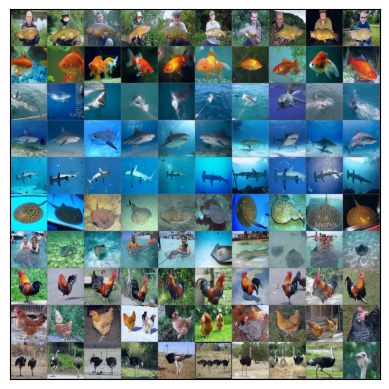

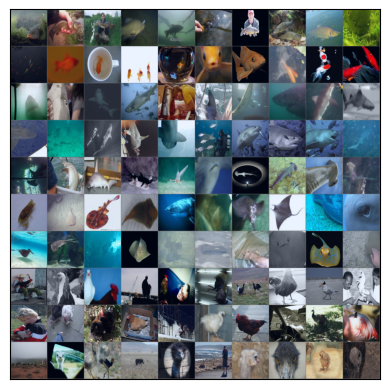

In [14]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        image_np = img.permute(1,2,0).numpy()
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
        axs[0, i].imshow(np.asarray(image_np))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

cr_npz = np.load('./analysis_checkpoints/imagenet/imagenet_index_curv.npz', allow_pickle=True)
curv_scores = pd.DataFrame.from_dict({item: cr_npz[item] for item in ['tr_filenames', 'cr_labels', 'tr_curv']})
curv_scores['idx'] = curv_scores.index

# Note we do a inner join on the filename so that we can uniquely match FZ score with curvature scores
combined_scores_df = fz_scores.merge(curv_scores, on='tr_filenames', how='inner')
combined_scores_df['tr_cuml_curv'] = cuml_scores_wd0
combined_scores_df.sort_values(by=['tr_labels', 'tr_cuml_curv'], inplace=True)

low_curv_idxs = []
high_curv_idxs = []
num_classes = 10
for class_idx in range(num_classes):
    df_for_class = combined_scores_df[(combined_scores_df['tr_labels'] == class_idx)].sort_values(by=['tr_cuml_curv'], ascending=True)
    low_curv_idxs.append(df_for_class['idx'][:10])
    high_curv_idxs.append(df_for_class['idx'][-10:])

low_curv_images = []
for class_wise_idxs in low_curv_idxs:
    for idx in class_wise_idxs:
        image, label = dataset.train_loader.dataset.__getitem__(idx)
        low_curv_images.append(image)

classes = [idx2label[class_label] for class_label in range(num_classes)]
print(f"Viz class labels {classes}")
low_curv_grid = torchvision.utils.make_grid(low_curv_images, nrow=num_classes)
show(low_curv_grid)

high_curv_images = []
for class_wise_idxs in high_curv_idxs:
    for idx in class_wise_idxs:
        image, label = dataset.train_loader.dataset.__getitem__(idx)
        high_curv_images.append(image)
high_curv_grid = torchvision.utils.make_grid(high_curv_images, nrow=num_classes)
show(high_curv_grid)

In [23]:
np.save("./curv_scores/imagenet_wd0.npy", cuml_scores_wd0)
np.save("./curv_scores/imagenet_wd1.npy", cuml_scores_wd1)

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

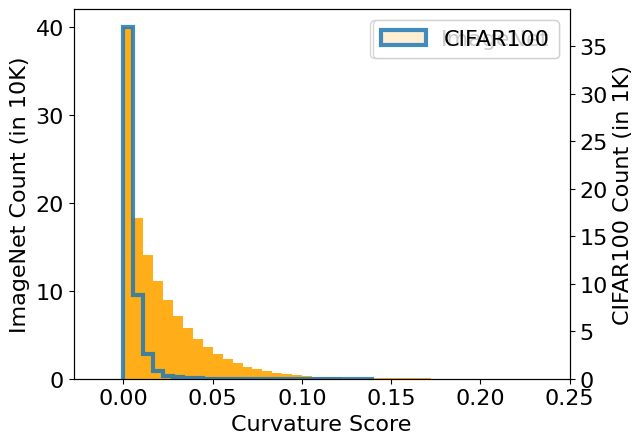

In [69]:
imagenet_scores = np.load("./curv_scores/imagenet_wd0.npy")
cifar100_scores = np.load("./curv_scores/cifar100_wd0.npy")
# Create a figure and axis objects

plt.rcParams.update({'font.size': 16, 'font.weight': 'normal'})

fig, ax = plt.subplots()
ax.hist(imagenet_scores, label='ImageNet', histtype='stepfilled', color='orange', bins=100, alpha=0.9)

ax2 = ax.twinx()
ax2.hist(cifar100_scores, label='CIFAR100', histtype="step", lw=3, bins=25, alpha=0.85)

def formatter1k(x, pos):
    return f"{x / 1000:.0f}"

def formatter100k(x, pos):
    return f"{x / 10000:.0f}"

ax2.yaxis.set_major_formatter(formatter1k)
ax.yaxis.set_major_formatter(formatter100k)

# Set the axis labels
ax.set_xlabel('Curvature Score')
ax2.set_ylabel('CIFAR100 Count (in 1K)')
ax.set_ylabel('ImageNet Count (in 10K)')

# Add a legend
ax.legend()
ax2.legend()

plt.xlim(right=0.25)
plt.savefig("./imagenet_hist.svg")
plt.show()